In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input
from darts.models import FFT
from darts import TimeSeries

# Heating Oil

## 7:3

In [2]:
# Đọc dữ liệu
df = pd.read_csv('../dataset/Heating Oil.csv')

In [3]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-05-31,2.3636,2.3690,2.3894,2.3508,1.74K,-0.24%
1,2024-05-30,2.3694,2.4305,2.4368,2.3637,18.12K,-2.77%
2,2024-05-29,2.4370,2.4801,2.4935,2.4295,22.87K,-1.14%
3,2024-05-28,2.4650,2.4148,2.4800,2.4131,28.96K,0.57%
4,2024-05-27,2.4510,2.4361,2.4660,2.4302,NaN,0.63%
...,...,...,...,...,...,...,...
1380,2019-03-07,2.0127,2.0124,2.0356,1.9988,48.59K,-0.17%
1381,2019-03-06,2.0162,2.0146,2.0256,1.9969,50.22K,-0.01%
1382,2019-03-05,2.0164,2.0110,2.0229,1.9909,45.16K,0.10%
1383,2019-03-04,2.0143,1.9999,2.0377,1.9984,56.05K,0.66%


In [5]:

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Đảo ngược dữ liệu để dự đoán giá trị trong tương lai
df = df.iloc[::-1].reset_index(drop=True)

In [6]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01,2.0010,2.0293,2.0479,1.9791,55010.0,-1.11
1,2019-03-04,2.0143,1.9999,2.0377,1.9984,56050.0,0.66
2,2019-03-05,2.0164,2.0110,2.0229,1.9909,45160.0,0.10
3,2019-03-06,2.0162,2.0146,2.0256,1.9969,50220.0,-0.01
4,2019-03-07,2.0127,2.0124,2.0356,1.9988,48590.0,-0.17
...,...,...,...,...,...,...,...
1319,2024-05-24,2.4136,2.4175,2.4302,2.3897,21870.0,0.07
1320,2024-05-28,2.4650,2.4148,2.4800,2.4131,28960.0,0.57
1321,2024-05-29,2.4370,2.4801,2.4935,2.4295,22870.0,-1.14
1322,2024-05-30,2.3694,2.4305,2.4368,2.3637,18120.0,-2.77


In [7]:
# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

In [8]:
price = df['Price'].values
price = price.reshape(-1, 1)

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [10]:
train_size = int(len(price_scaled) * 0.7)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
series_train = TimeSeries.from_dataframe(pd.DataFrame(train_data, columns=['Price']))
series_test = TimeSeries.from_dataframe(pd.DataFrame(test_data, columns=['Price']))

In [11]:
model = FFT()
model.fit(series_train)

FFT(nr_freqs_to_keep=10, required_matches=None, trend=None, trend_poly_degree=3)

In [12]:
forecast = model.predict(len(series_test))

In [13]:
rmse = np.sqrt(np.mean((series_test.values() - forecast.values()) ** 2))
mae = np.mean(np.abs(series_test.values() - forecast.values()))
mape = np.mean(np.abs((series_test.values() - forecast.values()) / series_test.values())) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')

RMSE: 0.2770819499797215
MAE: 0.26029627163243707
MAPE: 53.45380210549242%


In [14]:
forecast_90 = model.predict(len(series_test) + 90)
print(forecast_90)

<TimeSeries (DataArray) (time: 666, component: 1, sample: 1)> Size: 5kB
array([[[0.48045701]],

       [[0.47693555]],

       [[0.47341326]],

       [[0.46989122]],

       [[0.46637054]],

       [[0.46285234]],

       [[0.45933773]],

       [[0.45582783]],

       [[0.45232379]],

       [[0.44882675]],

...

       [[0.19979164]],

       [[0.2003296 ]],

       [[0.20085184]],

       [[0.20135867]],

       [[0.2018504 ]],

       [[0.20232737]],

       [[0.20278994]],

       [[0.20323852]],

       [[0.20367351]],

       [[0.20409535]]])
Coordinates:
  * time       (time) int64 5kB 1343 1344 1345 1346 1347 ... 2005 2006 2007 2008
  * component  (component) object 8B 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


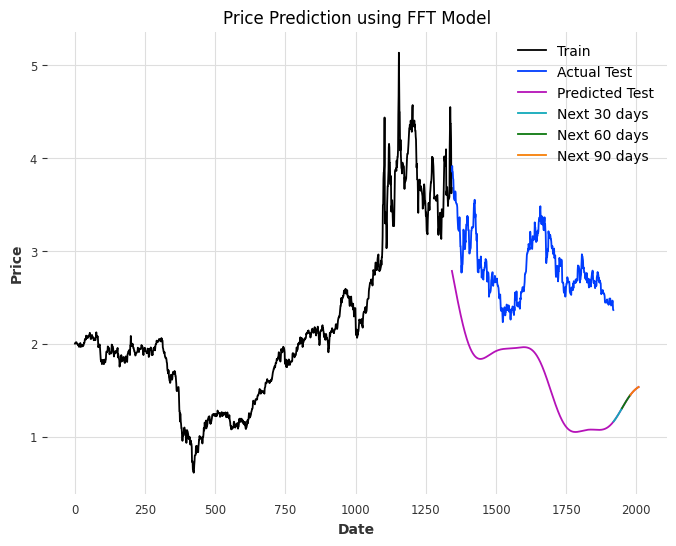

In [15]:
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), columns=['Price'])
test_predict_df = pd.DataFrame(scaler.inverse_transform(forecast_90.values()), columns=['Price'])

train_length = len(train_data_df)
test_length = len(test_data_df)
test_predict_length = len(test_predict_df)

test_data_df.index = range(train_length, train_length + test_length)
test_predict_df.index = range(train_length, train_length + test_predict_length)

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
file_path = '../latex/picture/FFT/FFT_Heating_73.png'
plt.savefig(file_path)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()

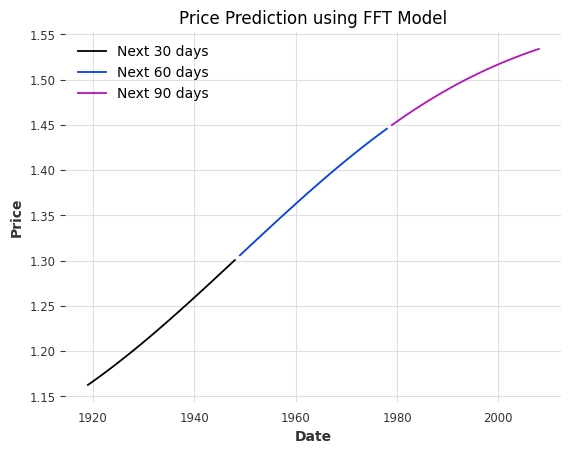

In [16]:
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()

## 8:2

In [17]:
train_size = int(len(price_scaled) * 0.8)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
series_train = TimeSeries.from_dataframe(pd.DataFrame(train_data, columns=['Price']))
series_test = TimeSeries.from_dataframe(pd.DataFrame(test_data, columns=['Price']))

In [18]:
model = FFT()
model.fit(series_train)

FFT(nr_freqs_to_keep=10, required_matches=None, trend=None, trend_poly_degree=3)

In [19]:
forecast = model.predict(len(series_test))

In [20]:
rmse = np.sqrt(np.mean((series_test.values() - forecast.values()) ** 2))
mae = np.mean(np.abs(series_test.values() - forecast.values()))
mape = np.mean(np.abs((series_test.values() - forecast.values()) / series_test.values())) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')

RMSE: 0.20735953465255044
MAE: 0.19260196148118713
MAPE: 39.93517262026295%


In [21]:
forecast_90 = model.predict(len(series_test) + 90)
print(forecast_90)

<TimeSeries (DataArray) (time: 474, component: 1, sample: 1)> Size: 4kB
array([[[0.35716768]],

       [[0.35595069]],

       [[0.35474599]],

       [[0.35355353]],

       [[0.35237324]],

       [[0.35120508]],

       [[0.35004896]],

       [[0.34890483]],

       [[0.3477726 ]],

       [[0.34665221]],

...

       [[0.09717347]],

       [[0.09782587]],

       [[0.09848796]],

       [[0.09915918]],

       [[0.09983896]],

       [[0.10052675]],

       [[0.10122197]],

       [[0.10192409]],

       [[0.10263252]],

       [[0.10334673]]])
Coordinates:
  * time       (time) int64 4kB 1535 1536 1537 1538 1539 ... 2005 2006 2007 2008
  * component  (component) object 8B 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


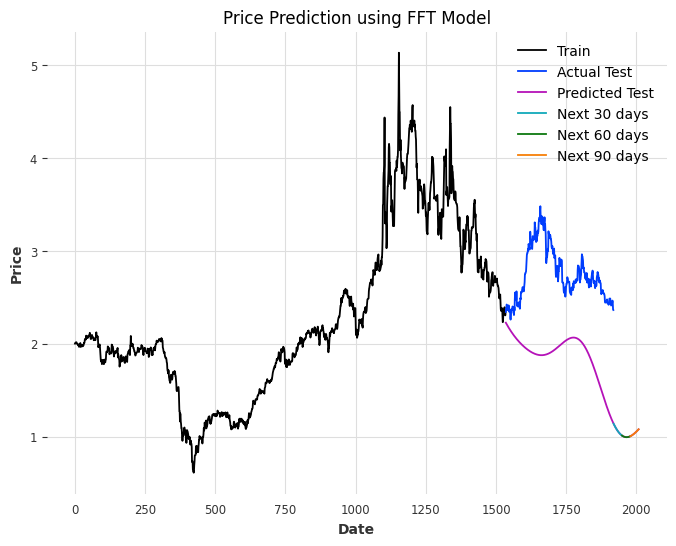

In [23]:
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), columns=['Price'])
test_predict_df = pd.DataFrame(scaler.inverse_transform(forecast_90.values()), columns=['Price'])

train_length = len(train_data_df)
test_length = len(test_data_df)
test_predict_length = len(test_predict_df)

test_data_df.index = range(train_length, train_length + test_length)
test_predict_df.index = range(train_length, train_length + test_predict_length)

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
file_path = '../latex/picture/FFT/FFT_Heating_82.png'
plt.savefig(file_path)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()

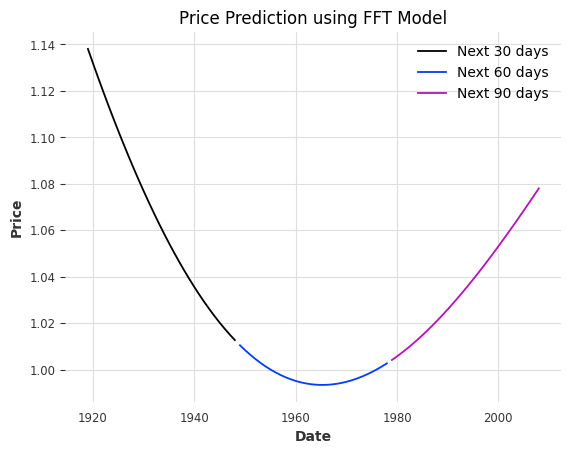

In [24]:
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()

### 9:1

In [25]:
train_size = int(len(price_scaled) * 0.9)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
series_train = TimeSeries.from_dataframe(pd.DataFrame(train_data, columns=['Price']))
series_test = TimeSeries.from_dataframe(pd.DataFrame(test_data, columns=['Price']))

In [26]:
model = FFT()
model.fit(series_train)

FFT(nr_freqs_to_keep=10, required_matches=None, trend=None, trend_poly_degree=3)

In [27]:
forecast = model.predict(len(series_test))

In [28]:
rmse = np.sqrt(np.mean((series_test.values() - forecast.values()) ** 2))
mae = np.mean(np.abs(series_test.values() - forecast.values()))
mape = np.mean(np.abs((series_test.values() - forecast.values()) / series_test.values())) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')

RMSE: 0.13428361309321002
MAE: 0.12408930507999494
MAPE: 27.57298971605505%


In [29]:
forecast_90 = model.predict(len(series_test) + 90)
print(forecast_90)

<TimeSeries (DataArray) (time: 282, component: 1, sample: 1)> Size: 2kB
array([[[0.43899724]],

       [[0.43772942]],

       [[0.43644937]],

       [[0.43515734]],

       [[0.43385359]],

       [[0.4325384 ]],

       [[0.43121204]],

       [[0.42987479]],

       [[0.42852693]],

       [[0.42716874]],

...

       [[0.27609035]],

       [[0.27567668]],

       [[0.27524911]],

       [[0.27480762]],

       [[0.27435221]],

       [[0.27388285]],

       [[0.27339956]],

       [[0.27290232]],

       [[0.27239116]],

       [[0.27186608]]])
Coordinates:
  * time       (time) int64 2kB 1727 1728 1729 1730 1731 ... 2005 2006 2007 2008
  * component  (component) object 8B 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


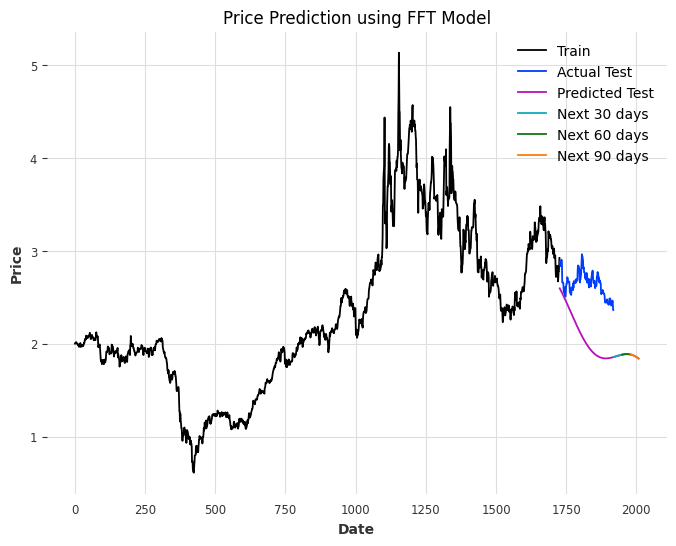

In [31]:
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), columns=['Price'])
test_predict_df = pd.DataFrame(scaler.inverse_transform(forecast_90.values()), columns=['Price'])

train_length = len(train_data_df)
test_length = len(test_data_df)
test_predict_length = len(test_predict_df)

test_data_df.index = range(train_length, train_length + test_length)
test_predict_df.index = range(train_length, train_length + test_predict_length)

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
file_path = '../latex/picture/FFT/FFT_Heating_91.png'
plt.savefig(file_path)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()

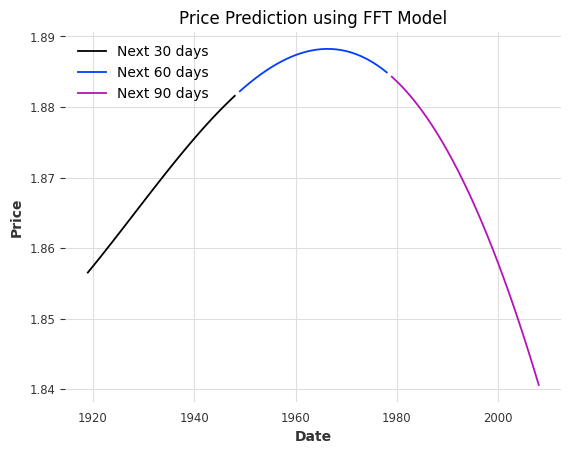

In [32]:
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()